# Start Pooling

In [97]:
#import general packages
import numpy as np
import geopandas as gpd
import pandas as pd
import matplotlib.pyplot as plt

#import climada stuff
from climada.entity.impact_funcs import trop_cyclone, impact_func_set
from climada.util.api_client import Client
from climada.engine import ImpactCalc

%load_ext autoreload
%autoreload 2
import exposures as ex
import grider as grd
import impact as cimp
import bound_prot_dam as bpd
import prem_ibrd as prib
import haz_int_grd as hig
import set_nominal as snom
import calc_premium as cp
import simulate_bond as sb
import alt_pay_opt as apo
import simulate_multi_cty_bond as smcb
client = Client()

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


## Define Countries and Variables for Cat Bond Development

In [98]:
#choose storm basin to load
#The STORM basins are: 'EP','NA','NI','SI','SP','WP'
#basins = ['NA','SI']

#choose country
country_1 = 174
country_2 = 584

#minimum damage to be protected per grid cell calculated using return period
lower_rp = 100

#number of simulated years
r = 10000

#set risk free rate, either single value or array
rf_rates = 0.05

#set range of premiums 
premiums = np.arange(0.00, 0.21, 0.01) 
#inititate IBRD premium calculation function
params_ibrd = prib.init_prem_ibrd(want_plot=False)
a, k, b = params_ibrd
#set risk muliplier reported by artems
artemis_multiplier = 4.11

#set sharpe ratio to beat
requ_sharpe_ratio = 1.0

#set the maximum amount to be protected
prot_share = 0.05

## Define Cat Bond function

In [99]:
def init_sng_cty_bond(country):    
    #load tc_tracks, create hazard class and calculate exposure
    exp, applicable_basins, storm_basin_sub, tc_storms = ex.init_TC_exp(country=country, load_fls=True)
    #set up grid for cat bond
    rst_grid = grd.init_grid(exp)
    #calculate impact and aggregate impact per grid
    imp, imp_per_exp, agg_exp, imp_grid_evt = cimp.init_imp(exp, tc_storms, rst_grid) 
    #set up hazard intensity matrix per grid and event
    ws_grid = hig.init_ws_grid(tc_storms, agg_exp, 'max')
    #set principal
    nominal, tot_exp, nom_rel_exp = snom.init_nominal(impact=imp, exposure=exp, prot_share=prot_share)
    #calculate damage return period and set small damages, not intended to protect to zero
    rp_dam_grid, dam_rp_per_grid, imp_grid_evt_flt = bpd.init_dam_ret_per_grid(imp_grid_evt, lower_rp, adj_max=False, plt_dam_rp_grid=None)
    #optimize minimum and maximum triggering wind speed per grid cell
    result, optimized_xs, optimized_ys = apo.init_alt_optimization(ws_grid, imp_grid_evt_flt, nominal)
    #create data frame containing payment vs damage per event
    pay_dam_df = apo.alt_pay_vs_damage(imp_grid_evt_flt, optimized_xs, optimized_ys, ws_grid, nominal, include_plot=False)
    #calculate yearly event probability
    event_probability = len(pay_dam_df) / r
    #calculate expected loss and attachment probability
    exp_loss_ann, att_prob = sb.init_exp_loss_att_prob_simulation(pay_dam_df, nominal, event_probability)
    #calculate premiums using different approaches
    premium_ibrd = prib.monoExp(exp_loss_ann*100, a, k, b)/100
    premium_artemis = exp_loss_ann * artemis_multiplier
    premium_regression = cp.calc_premium_regression(exp_loss_ann *100)/100

    print(f'The premium based on past IBRD bonds is {round(premium_ibrd*100, 3)}%')
    print(f'The premium based on the artemis multiplier is {round(premium_artemis*100, 3)}%')
    print(f'The premium based on the regression model from Chatoro et al. 2022 is {round(premium_regression*100, 3)}%')

    #simulate cat bond
    premium_simulation, returns = sb.init_bond_simulation(pay_dam_df, premiums, rf_rates, event_probability, nominal) #simulate cat bond using a Monte Carlo simulation
    #determine premium to match required sharp ratio
    requ_premiums = sb.init_requ_premium(requ_sharpe_ratio, premium_simulation, rf_rates) #calculate required premium to match minimum sharpe ratio
    sb.display_premiums([requ_premiums], [requ_sharpe_ratio], rf_rates, premium_simulation, exp_loss_ann)   #plot premium versus sharpe ratio

    return premium_simulation, exp_loss_ann, att_prob, requ_premiums, nominal, pay_dam_df, event_probability

### Design Cat Bond for Country 1

STORM basin of country:  WP
----------------------Loading Exposure----------------------
----------------------Loading Hazard----------------------


c:\Users\kaibe\Documents\ETH_Zurich\Thesis\Code\grider.py:93: UserWarning: Legend does not support handles for PatchCollection instances.
See: https://matplotlib.org/stable/tutorials/intermediate/legend_guide.html#implementing-a-custom-legend-handler
  plt.legend()
c:\Users\kaibe\Documents\ETH_Zurich\Thesis\Code\grider.py:93: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend()


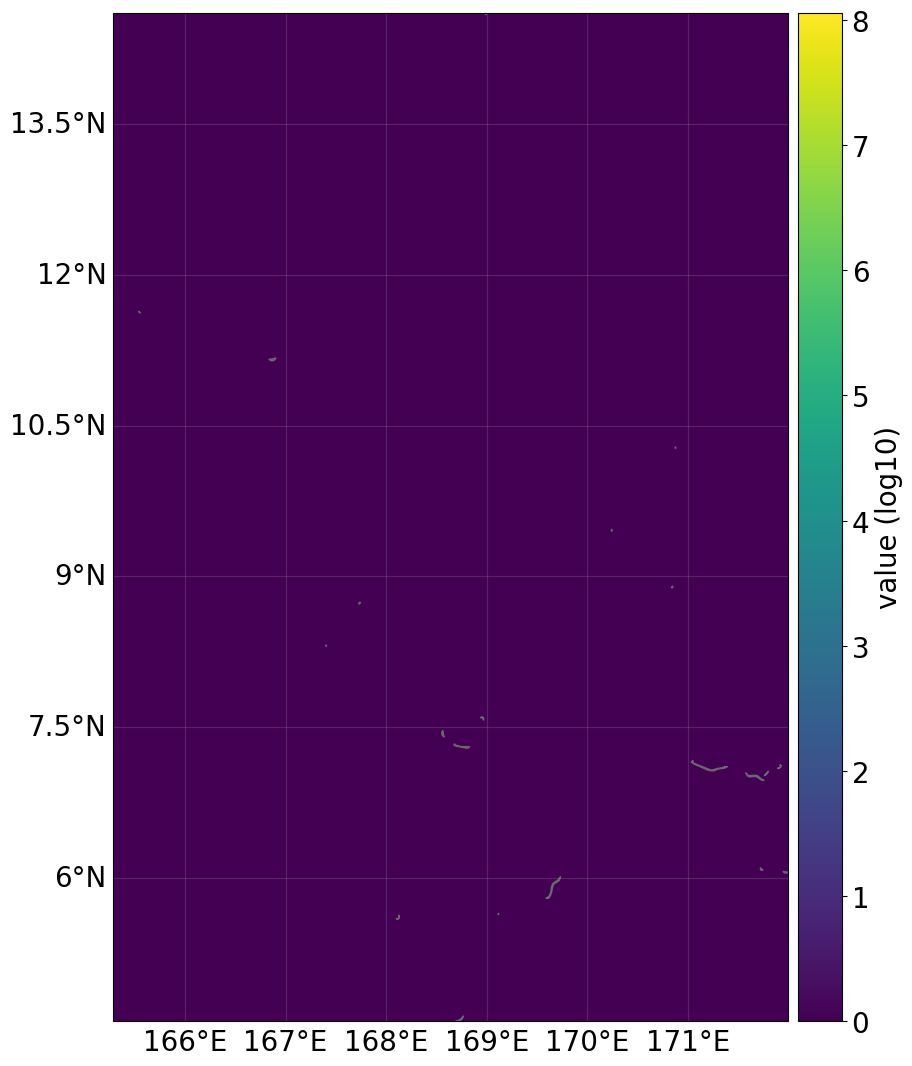

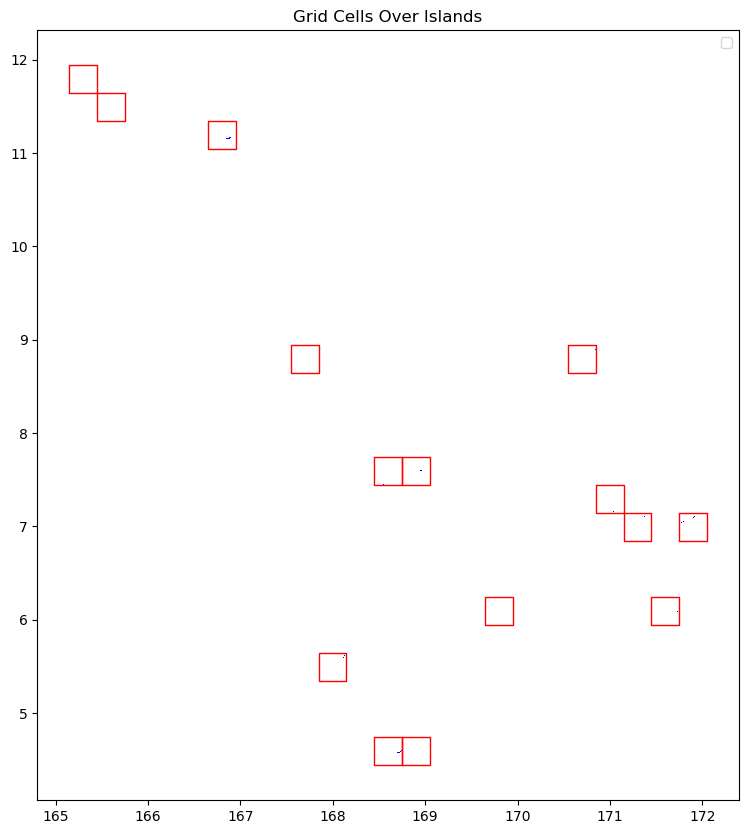

The principal of the cat bond is: 12037557.220459
Principal as perecntage of GDP: 0.05
{0: (40.0, 150.0), 1: (40.0, 150.0), 2: (40.0, 150.0), 3: (21.270862929739586, 66.63956186856961), 4: (40.0, 150.0), 5: (40.0, 150.0), 6: (40.0, 150.0), 7: (40.0, 150.0), 8: (40.0, 150.0), 9: (40.0, 150.0), 10: (40.0, 150.0), 11: (36.66902648637075, 147.62124354985673), 12: (20.0, 51.0), 13: (40.0, 150.0), 14: (40.0, 150.0)}
Expected Loss = 0.013143648172522233
Attachment Probability = 0.0286
The premium based on past IBRD bonds is 3.266%
The premium based on the artemis multiplier is 5.402%
The premium based on the regression model from Chatoro et al. 2022 is 6.127%
Intersection point using risk free interest rate of 5.0%: Premium = 0.0811, Sharpe Ratio = 1.0000
Required Sharpe Ratio: 1.0; Risk free rate: 5.0%; Required Premium: 8.105%; Risk Multiple: 6.167


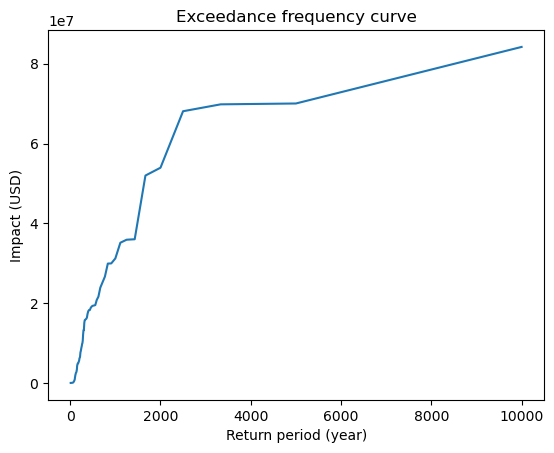

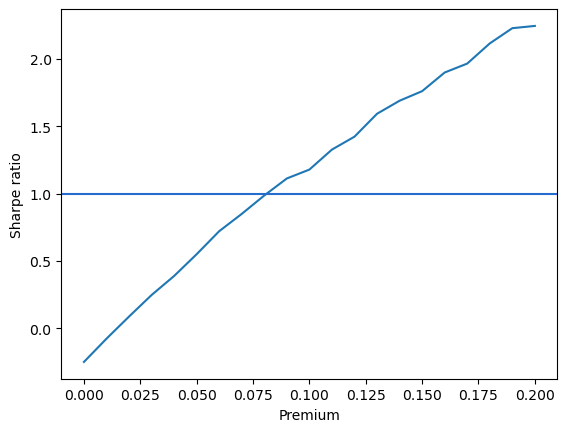

In [100]:
premium_simulation_662, exp_loss_ann_662, att_prob_662, requ_premiums_662, nominal_662, pay_dam_df_662, event_probability_662 = init_sng_cty_bond(country=country_2)

### Design Cat Bond for Country 2

STORM basin of country:  SI
----------------------Loading Exposure----------------------
----------------------Loading Hazard----------------------


c:\Users\kaibe\Documents\ETH_Zurich\Thesis\Code\grider.py:93: UserWarning: Legend does not support handles for PatchCollection instances.
See: https://matplotlib.org/stable/tutorials/intermediate/legend_guide.html#implementing-a-custom-legend-handler
  plt.legend()
c:\Users\kaibe\Documents\ETH_Zurich\Thesis\Code\grider.py:93: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend()


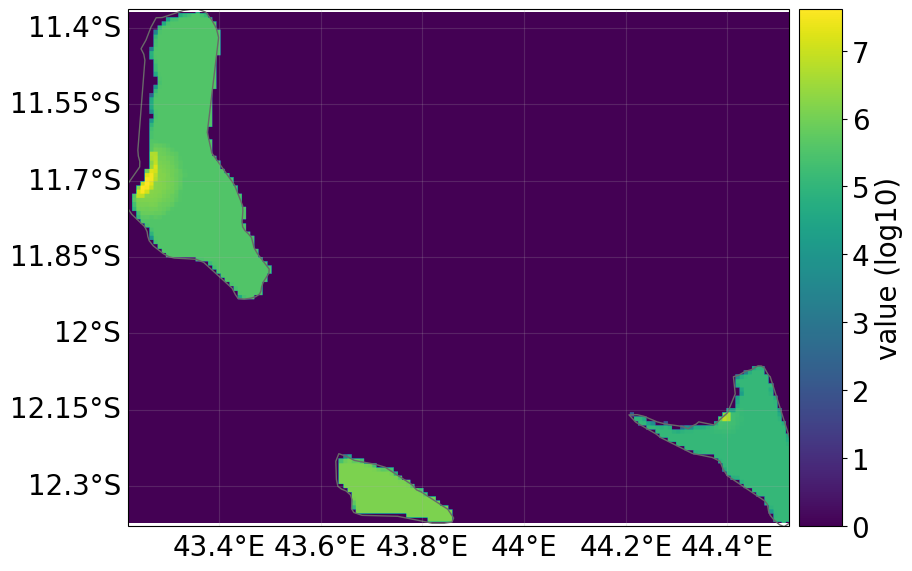

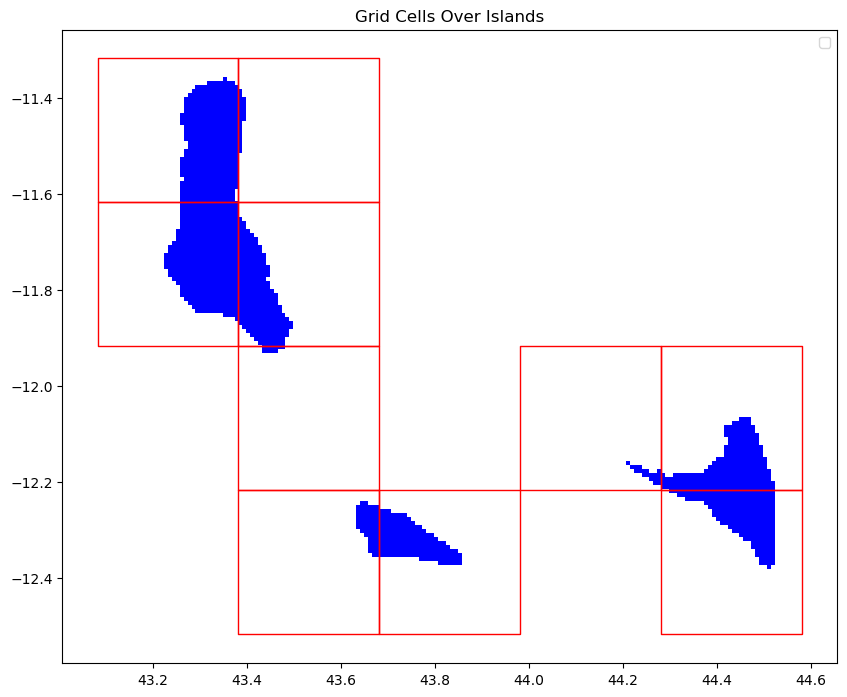

The principal of the cat bond is: 61251959.8305455
Principal as perecntage of GDP: 0.05
{0: (20.0, 51.0), 1: (20.000116723224178, 132.66814115672378), 2: (20.000004581600912, 102.00197869891875), 3: (36.139507905725885, 149.21571066944114), 4: (20.0, 141.65843056519293), 5: (21.889515090918913, 69.32662224349065), 6: (38.3359846110904, 149.27924818495634), 7: (40.0, 150.0), 8: (24.00602039069312, 148.9097028189082), 9: (28.43445496779605, 148.93654953915708)}
Expected Loss = 0.011182991443817056
Attachment Probability = 0.016099999999999996
The premium based on past IBRD bonds is 3.501%
The premium based on the artemis multiplier is 4.596%
The premium based on the regression model from Chatoro et al. 2022 is 5.853%
Intersection point using risk free interest rate of 5.0%: Premium = 0.0884, Sharpe Ratio = 1.0000
Required Sharpe Ratio: 1.0; Risk free rate: 5.0%; Required Premium: 8.835%; Risk Multiple: 7.901


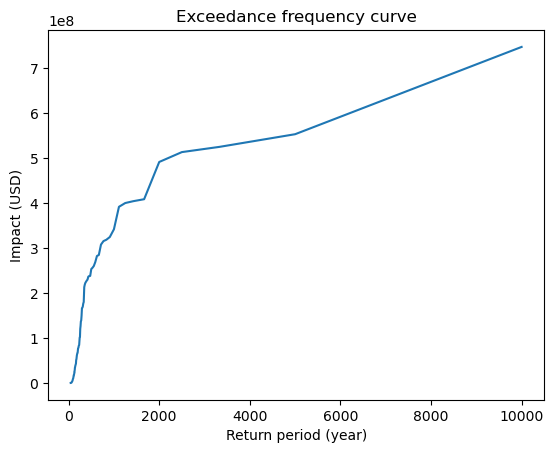

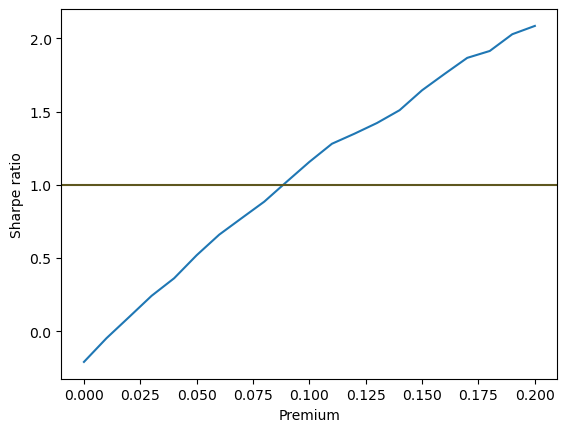

In [101]:
premium_simulation_174, exp_loss_ann_174, att_prob_174, requ_premiums_174, nominal_174, pay_dam_df_174, event_probability_174 = init_sng_cty_bond(country=country_1)

### Set Variables for Multi-Country Bond

In [102]:
pay_dam_df_dic = {country_1: pay_dam_df_174,
                  country_2: pay_dam_df_662}

event_probabilities = [event_probability_174, event_probability_662]

nominal_pool = nominal_174 + nominal_662
print(nominal_pool)

73289517.0510045


### Create Multi-Country bond

Expected Loss = 0.01192754094579896
Attachment Probability = 0.04433333333333333
Intersection point using risk free interest rate of 5.0%: Premium = 0.0762, Sharpe Ratio = 1.0000
Required Sharpe Ratio: 1.0; Risk free rate: 5.0%; Required Premium: 7.624%; Risk Multiple: 6.392


c:\Users\kaibe\Documents\ETH_Zurich\Thesis\Code\simulate_bond.py:203: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  x_intersection = fsolve(intersection_func, x_guess)[0]


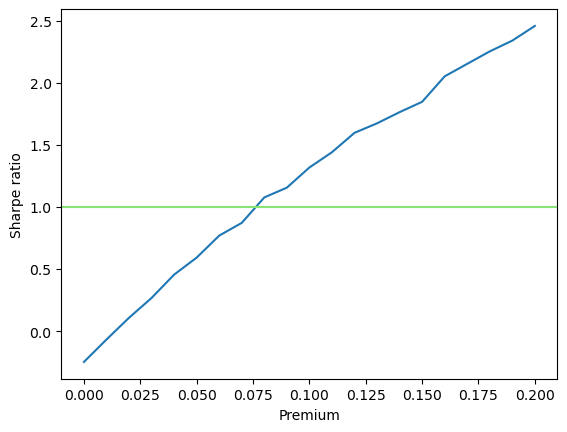

In [103]:
exp_loss_pool, att_prob_pool = smcb.init_exp_loss_att_prob_simulation(pay_dam_df_dic, nominal_pool, event_probabilities)
metrics_pool, returns_pool = smcb.init_bond_simulation(pay_dam_df_dic, premiums, rf_rates, event_probabilities, nominal_pool)

requ_premiums = sb.init_requ_premium(requ_sharpe_ratio, metrics_pool, rf_rates) #calculate required premium to match minimum sharpe ratio
sb.display_premiums([requ_premiums], [requ_sharpe_ratio], rf_rates, metrics_pool, exp_loss_pool)   #plot premium versus sharpe ratio

In [104]:
premium_ibrd = prib.monoExp(exp_loss_pool*100, a, k, b) * exp_loss_pool
premium_artemis = exp_loss_pool * artemis_multiplier
premium_regression = cp.calc_premium_regression(exp_loss_pool *100)/100

print(f'Premium IBRD: {premium_ibrd*100}%')
print(f'Premium Artemis: {premium_artemis*100}%')
print(f'Premium Regression: {premium_regression*100}%')

Premium IBRD: 4.064905961654246%
Premium Artemis: 4.902219328723373%
Premium Regression: 5.957224876679443%


In [105]:
print(premium_simulation_662['Coverage'].mean())
print(premium_simulation_174['Coverage'].mean())
print(metrics_pool['Coverage'].mean())

1.2085303646418903
0.5237419876955052
0.5904802396326086


In [108]:
tot_prem_sng_cty = nominal_174*requ_premiums_174 + nominal_662*requ_premiums_662
tot_prem_pool = nominal_pool*requ_premiums
print(tot_prem_sng_cty)
print(tot_prem_pool)

print((tot_prem_sng_cty-tot_prem_pool)/(tot_prem_sng_cty))

6387413.880980184
5587284.792295956
0.12526651687105705
